## import libraries

In [33]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr
from function import calc_drt

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import viridis
from matplotlib.cm import ScalarMappable
import matplotlib
from matplotlib.widgets import Slider,CheckButtons
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from scipy.signal import savgol_filter,find_peaks
from tqdm import tqdm

import time
from collections import Counter
from pandas import Series

from impedance.visualization import plot_nyquist, plot_residuals, plot_bode
from impedance import preprocessing
from impedance.validation import linKK
from impedance.models.circuits import CustomCircuit

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor


# Data processing

## Data visualization (time domain)

In [2]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
db = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008'] #,,'cell002'

Q_all = Series()

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.form_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `CE/%`, `Q_relative`, `cycle_Nr` FROM capacity WHERE `cycle_Nr`>4'
    Q = pd.read_sql(sql, Connection)
    Q.insert(Q.shape[1],'I(uA)',i)
    Q.insert(Q.shape[1],'cell_ID',cell)
    Q_all = pd.concat([Q_all,Q])


Q_all.insert(Q_all.shape[1],'I(uA)_rgl',
             (Q_all['I(uA)'] - Q_all['I(uA)'].min()) / (Q_all['I(uA)'].max() - Q_all['I(uA)'].min()))

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\2423119064.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Q_all = Series()
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\2423119064.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  control_i = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\2423119064.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Q = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\2423119064.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/conn

<IPython.core.display.Javascript object>


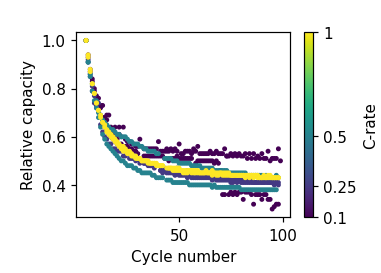

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\4172399688.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_data = Q_all[Q['cell_ID']==cell]


In [4]:
%matplotlib notebook

plt.figure(figsize=(3.5,2.5))

cmap = viridis

norm_I = Q_all['I(uA)_rgl']

cells = Q_all['cell_ID'].unique()
    
for cell in cells:
    cell_data = Q_all[Q['cell_ID']==cell]
    plt.scatter(cell_data['cycle_Nr'], cell_data['Q_relative'], # label=cell, 
                s=5, c=cell_data['I(uA)_rgl'], cmap=cmap) # c=cell_mean_colors.get(cell, None), 

    
plt.xlabel('Cycle number') #{'size':10})
plt.ylabel('Relative capacity') #, {'size':10})
# plt.title('relative capacity vs. cycle number', {'size':10})
# plt.legend()

colorbar = plt.colorbar(label='C-rate')  # 添加颜色条

# 定义colorbar的刻度尺度
ticks = [0, 0.167, 0.44, 1]  
tick_labels = ['0.1', '0.25', '0.5', '1'] 
# 设置colorbar的刻度和标签
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(tick_labels)

plt.show()
plt.subplots_adjust(bottom=0.2, left=0.2) 
# plt.savefig('Q_relative_vs_CycleNr.png')

<IPython.core.display.Javascript object>


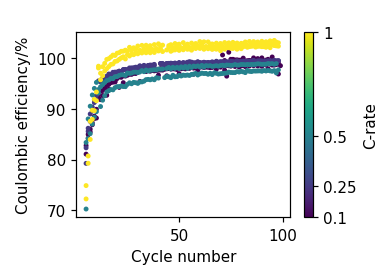

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\385284460.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_data = Q_all[Q['cell_ID']==cell]


In [5]:
%matplotlib notebook

plt.figure(figsize=(3.5,2.5))

norm_I = Q_all['I(uA)_rgl']

cells = Q_all['cell_ID'].unique()

for cell in cells:
    cell_data = Q_all[Q['cell_ID']==cell]
    plt.scatter(cell_data['cycle_Nr'], cell_data['CE/%'], s=5, c=cell_data['I(uA)_rgl'], cmap=cmap)

#plt.legend()
    
plt.xlabel('Cycle number')
plt.ylabel('Coulombic efficiency/%')
# plt.title('CE/% vs cycle number')

colorbar = plt.colorbar(label='C-rate')  # 添加颜色条

# 定义colorbar的刻度尺度
ticks = [0, 0.167, 0.44, 1]  
tick_labels = ['0.1', '0.25', '0.5', '1'] 

# 设置colorbar的刻度和标签
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(tick_labels)

plt.subplots_adjust(bottom=0.2, left=0.2) 

plt.show()

<IPython.core.display.Javascript object>


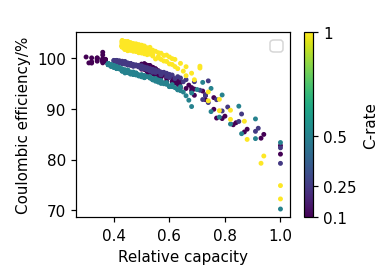

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3296065896.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_data = Q_all[Q['cell_ID']==cell]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to 

In [6]:
%matplotlib notebook
plt.figure(figsize=(3.5,2.5))

norm_I = Q_all['I(uA)_rgl']

cells = Q_all['cell_ID'].unique()

for cell in cells:
    cell_data = Q_all[Q['cell_ID']==cell]
    plt.scatter(cell_data['Q_relative'], cell_data['CE/%'], s=5, c=cell_data['I(uA)_rgl'], cmap=cmap)
    plt.legend()
    
plt.xlabel('Relative capacity')
plt.ylabel('Coulombic efficiency/%')
# plt.title('coulombic efficiency/% vs relative capacity')

colorbar = plt.colorbar(label='C-rate')  # 添加颜色条

# 定义colorbar的刻度尺度
ticks = [0, 0.167, 0.44, 1]  
tick_labels = ['0.1', '0.25', '0.5', '1'] 


# 设置colorbar的刻度和标签
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(tick_labels)

plt.subplots_adjust(bottom=0.2, left=0.2) 

plt.show()

## Data visualization (frequency domain) 
### EIS plots of each cell and LinKK test results

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\4002754260.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


<IPython.core.display.Javascript object>


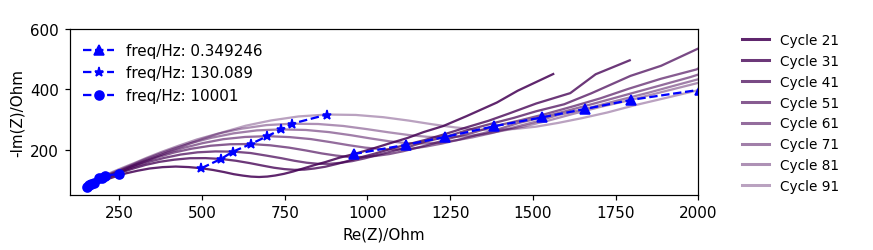

<IPython.core.display.Javascript object>


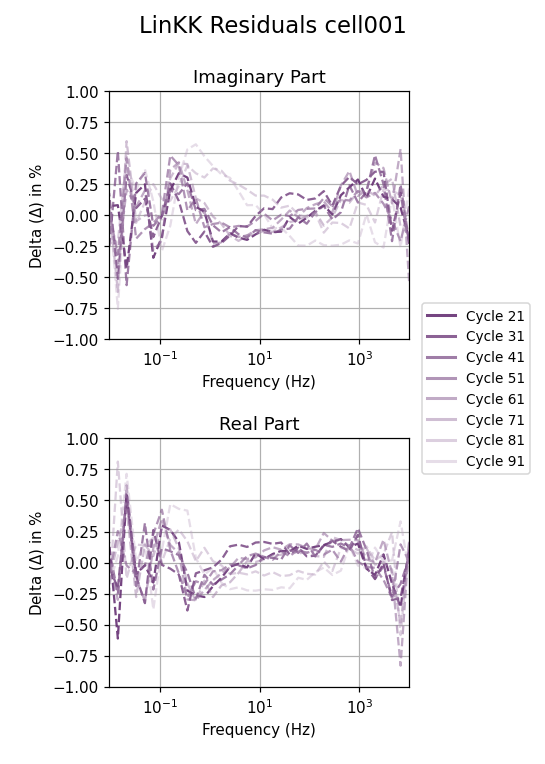

10 1.0 3.417415733653778
20 0.9306310282478522 3.2324740248490706
10 1.0 3.4952979023298187
20 0.9985546871593867 3.2433417829501763
10 1.0 4.553113142681247
20 0.9420974874663177 4.157936826879476
10 1.0 3.7054299289418284
20 0.9975915864175856 3.419453329520197
10 1.0 5.2557625865211905
20 0.9096276899823463 4.8342282957649365
10 1.0 5.692803332763314
20 0.9712115600267451 5.341815209230894
10 1.0 6.694017283003803
20 0.9501485773027005 5.992435656195977
10 1.0 8.733349301469806
20 0.9746232795441738 8.213567389884949


<IPython.core.display.Javascript object>


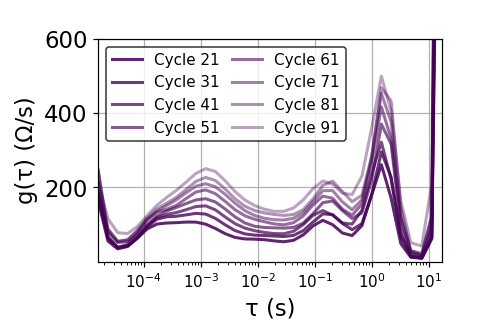

<IPython.core.display.Javascript object>


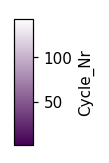

In [146]:
%matplotlib notebook

color_norm = {}
for cell in ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']:
    cell_data = Q_all[Q_all['cell_ID'] == cell]
    color_cell = cell_data['I(uA)_rgl'][5]
    color_norm[cell]= color_cell

color = (plt.cm.viridis(color_norm['cell001'])) # define the color based on the I(uA)

dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
cell = 'cell001' # define the cell

Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis WHERE `cycle_Nr`>20 '
cellx_df = pd.read_sql(sql, Connection)

# plot EIS
fig = plt.figure(figsize=(8,2.3))
ax = plt.axes()
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
    Z_log = np.log10(Z)
    ax.plot(Z[:, 0], Z[:, 1],'-',alpha= 1-0.007*i,c=color,lw=1.5)
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
Cycle_legend = ax.legend(handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.05, 1.05), #upper right outside the plot
    frameon=False,
    fontsize=9,
    ncol=1)
ax.add_artist(Cycle_legend)       


[low,medium,high]=[0.349246,130.089,10001]
for freq in [low,medium,high]:
    if freq<1.2:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='^', label='freq/Hz: '+str(freq),c='b')
    elif 100<freq<8000:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='*', label='freq/Hz: '+str(freq),c='b')
    else:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='o', label='freq/Hz: '+str(freq),c='b')

ax.set_xlabel("Re(Z)/Ohm",{'size':10})
ax.set_ylabel("-Im(Z)/Ohm",{'size':10})

plt.subplots_adjust(right=0.8)
plt.xlim((100,2000))
plt.ylim((50,600))
plt.yticks([200,400,600])
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(prop={'size':10}, loc='upper left',frameon=False) #bbox_to_anchor=(0, 1)
plt.gcf().subplots_adjust(left=0.08,bottom=0.22)

colors = [color[:3],(1,1,1)]
cmap_name = 'cell_color'
cml = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
norm = matplotlib.colors.Normalize(vmin=1, vmax=143)



# plot LinKK test error
fig = plt.figure(figsize=(5,7))
legend_elements = []

for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j * Z[:, 1]
    M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=0.8, max_M=100, fit_type='complex', add_cap=True)
    alpha = 1 - 0.007 * i
    color_i = cml(norm(i))  # define colormap and norm

    # subplot1 error of imaginary part
    ax1 = plt.subplot(211)
    ax1.plot(f, res_imag * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax1.set_title('Imaginary Part')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(f[-1], f[0])
    ax1.set_xlabel('Frequency (Hz)', {'size': 10})
    ax1.set_ylabel('Delta ($\Delta$) in %', {'size': 10})
    
    # subplot2 error of real part
    plt.subplots_adjust(right=0.75)
    ax2 = plt.subplot(212)
    ax2.plot(f, res_real * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax2.set_title('Real Part')
    ax2.set_xscale('log')
    ax2.grid(True)
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(f[-1], f[0])
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Delta ($\Delta$) in %')    

    # legend handle
    legend_elements.append(Line2D([0], [0], color=color_i, alpha=alpha, lw=2, label=f'Cycle {i}'))

plt.suptitle('LinKK Residuals ' + str(cell), fontsize=15, y=0.98)
plt.subplots_adjust(left=0.2, bottom=0.1, hspace=0.4)  # leave place for achse and legend

# add legend next to subplot2 in right upper
ax2.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 1.2),
    ncol=1,
    fontsize=9,
    frameon=True,
    facecolor='white'
)



# plot DRT 
plt.figure(figsize=(4.5,3))
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j*Z[:, 1]
    iter = 1000  # Example number of iterations
    drt = calc_drt.calc_drt(Z.real, Z.imag, f, iter)
    tau = 1/(f*2*np.pi)
    plt.plot(tau, drt, '-', c=color, alpha= 1-0.007*i, lw=2, label=f'Cycle {i}')
    drt = drt.flatten()
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
    plt.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    ncol=2,
    columnspacing=0.8,
    frameon=True,
   facecolor='white',
   edgecolor='black',
    handlelength=2)

    plt.xscale("log")
    plt.xlim(tau[0], tau[-1])
    plt.ylim(0, 600)
    plt.yticks([200,400,600])
    plt.xlabel('τ (s)', fontdict={'size':15})
    plt.ylabel('g(τ) (Ω/s)', fontdict={'size':15})
    plt.xticks(size=10)
    plt.yticks(size=15)
    plt.grid(True)
    plt.gcf().subplots_adjust(left=0.2,bottom=0.2)

    
# plot colorbar
fig, ax = plt.subplots(figsize=(1, 1.5))
fig.subplots_adjust(right=0.3)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cml,norm=norm), cax=ax, orientation='vertical',label='Cycle_Nr')

plt.show()

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\2767555899.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


<IPython.core.display.Javascript object>


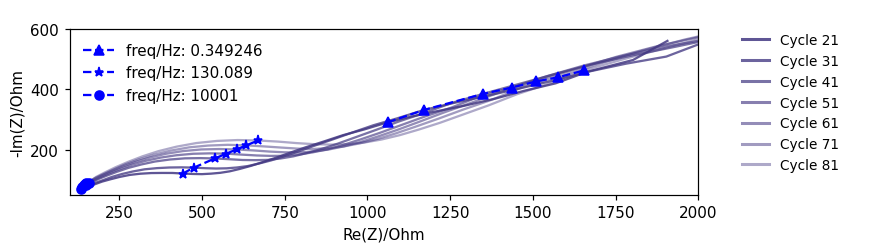

<IPython.core.display.Javascript object>


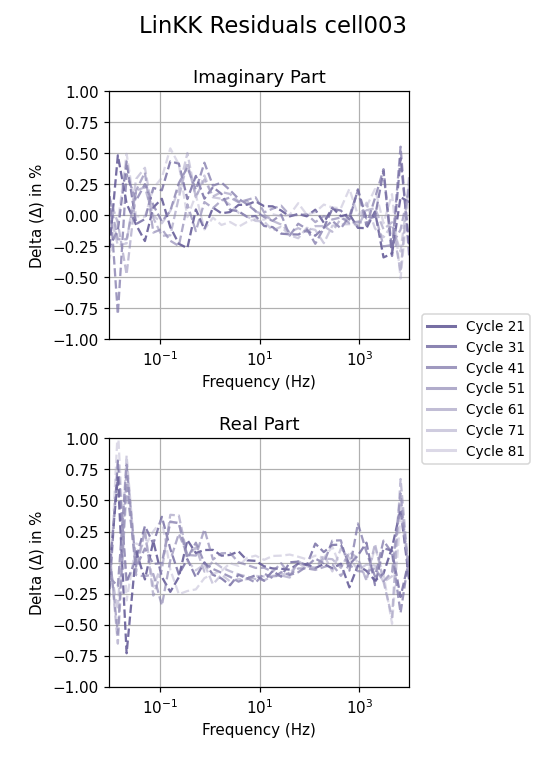

10 1.0 4.29836038243726
20 0.9933411942494446 3.8150124322750245
10 1.0 4.938928213421237
20 0.9079899737723559 4.338327148136945
10 1.0 5.909053587915397
20 0.9439080216137834 5.459377030167296
10 1.0 5.7862331864212315
20 0.9717829062446264 5.101578324880893
10 1.0 6.023369096140453
20 1.0 5.68110154563982
10 1.0 6.804112217864738
20 0.9356320938219423 6.115218317029195
10 1.0 7.95772991747332
20 1.0 7.6347297159720044


<IPython.core.display.Javascript object>


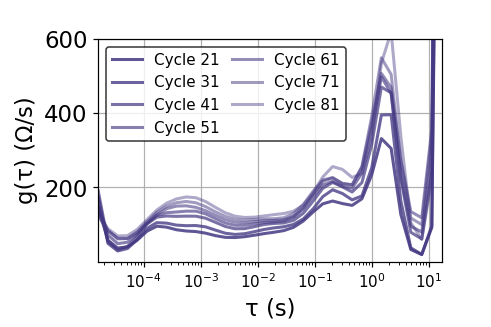

<IPython.core.display.Javascript object>


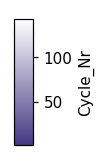

In [147]:
%matplotlib notebook

color_norm = {}
for cell in ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']:
    cell_data = Q_all[Q_all['cell_ID'] == cell]
    color_cell = cell_data['I(uA)_rgl'][5]
    color_norm[cell]= color_cell

color = (plt.cm.viridis(color_norm['cell003'])) # define the color based on the I(uA)

dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
cell = 'cell003' # define the cell

Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis WHERE `cycle_Nr`>20 '
cellx_df = pd.read_sql(sql, Connection)

# plot EIS
fig = plt.figure(figsize=(8,2.3))
ax = plt.axes()
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
    Z_log = np.log10(Z)
    ax.plot(Z[:, 0], Z[:, 1],'-',alpha= 1-0.007*i,c=color,lw=1.5)
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
Cycle_legend = ax.legend(handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.05, 1.05), #upper right outside the plot
    frameon=False,
    fontsize=9,
    ncol=1)
ax.add_artist(Cycle_legend)       


[low,medium,high]=[0.349246,130.089,10001]
for freq in [low,medium,high]:
    if freq<1.2:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='^', label='freq/Hz: '+str(freq),c='b')
    elif 100<freq<8000:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='*', label='freq/Hz: '+str(freq),c='b')
    else:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='o', label='freq/Hz: '+str(freq),c='b')

ax.set_xlabel("Re(Z)/Ohm",{'size':10})
ax.set_ylabel("-Im(Z)/Ohm",{'size':10})

plt.subplots_adjust(right=0.8)
plt.xlim((100,2000))
plt.ylim((50,600))
plt.yticks([200,400,600])
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(prop={'size':10}, loc='upper left',frameon=False) #bbox_to_anchor=(0, 1)
plt.gcf().subplots_adjust(left=0.08,bottom=0.22)

colors = [color[:3],(1,1,1)]
cmap_name = 'cell_color'
cml = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
norm = matplotlib.colors.Normalize(vmin=1, vmax=143)



# plot LinKK test error
fig = plt.figure(figsize=(5,7))
legend_elements = []

for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j * Z[:, 1]
    M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=0.8, max_M=100, fit_type='complex', add_cap=True)
    alpha = 1 - 0.007 * i
    color_i = cml(norm(i))  # define colormap and norm

    # subplot1 error of imaginary part
    ax1 = plt.subplot(211)
    ax1.plot(f, res_imag * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax1.set_title('Imaginary Part')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(f[-1], f[0])
    ax1.set_xlabel('Frequency (Hz)', {'size': 10})
    ax1.set_ylabel('Delta ($\Delta$) in %', {'size': 10})
    
    # subplot2 error of real part
    plt.subplots_adjust(right=0.75)
    ax2 = plt.subplot(212)
    ax2.plot(f, res_real * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax2.set_title('Real Part')
    ax2.set_xscale('log')
    ax2.grid(True)
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(f[-1], f[0])
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Delta ($\Delta$) in %')    

    # legend handle
    legend_elements.append(Line2D([0], [0], color=color_i, alpha=alpha, lw=2, label=f'Cycle {i}'))

plt.suptitle('LinKK Residuals ' + str(cell), fontsize=15, y=0.98)
plt.subplots_adjust(left=0.2, bottom=0.1, hspace=0.4)  # leave place for achse and legend

# add legend next to subplot2 in right upper
ax2.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 1.2),
    ncol=1,
    fontsize=9,
    frameon=True,
    facecolor='white'
)



# plot DRT 
plt.figure(figsize=(4.5,3))
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j*Z[:, 1]
    iter = 1000  # Example number of iterations
    drt = calc_drt.calc_drt(Z.real, Z.imag, f, iter)
    tau = 1/(f*2*np.pi)
    plt.plot(tau, drt, '-', c=color, alpha= 1-0.007*i, lw=2, label=f'Cycle {i}')
    drt = drt.flatten()
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
    plt.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    ncol=2,
    columnspacing=0.8,
    frameon=True,
   facecolor='white',
   edgecolor='black',
    handlelength=2)

    plt.xscale("log")
    plt.xlim(tau[0], tau[-1])
    plt.ylim(0, 600)
    plt.yticks([200,400,600])
    plt.xlabel('τ (s)', fontdict={'size':15})
    plt.ylabel('g(τ) (Ω/s)', fontdict={'size':15})
    plt.xticks(size=10)
    plt.yticks(size=15)
    plt.grid(True)
    plt.gcf().subplots_adjust(left=0.2,bottom=0.2)

    
# plot colorbar
fig, ax = plt.subplots(figsize=(1, 1.5))
fig.subplots_adjust(right=0.3)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cml,norm=norm), cax=ax, orientation='vertical',label='Cycle_Nr')

plt.show()

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\1721639271.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


<IPython.core.display.Javascript object>


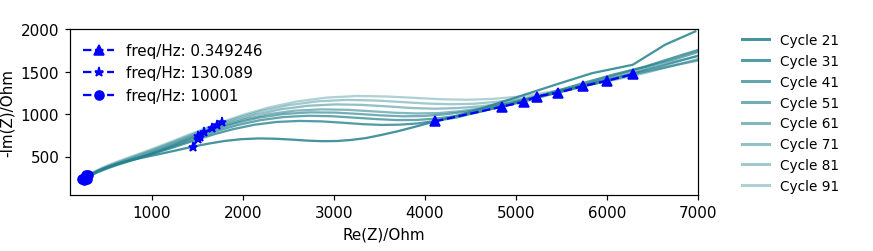

<IPython.core.display.Javascript object>


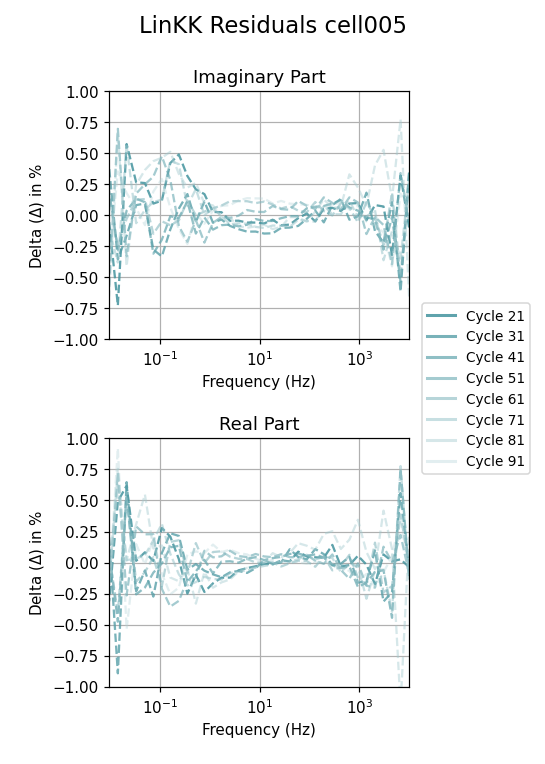

10 1.0 17.664790257954305
20 0.979427587622296 16.39273472271608
10 1.0 20.12560922381868
20 0.9402732973607063 18.397689967351376
10 1.0 15.676370962380929
20 1.0 13.925366171815957
10 1.0 26.1613102715264
20 0.9231902241897465 22.29080233590834
10 1.0 15.40726822676241
20 0.9992310278318561 13.337833378523683
10 1.0 19.659469249285674
20 0.9403328264597655 17.681704735154177
10 1.0 31.804569503197445
20 0.8915176303423472 27.999366384910363
10 1.0 25.97542281606252
20 0.994767618914323 22.748896938739776


<IPython.core.display.Javascript object>


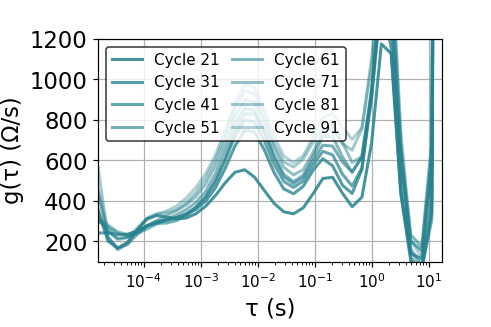

<IPython.core.display.Javascript object>


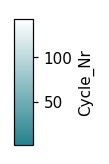

In [141]:
%matplotlib notebook

color_norm = {}
for cell in ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']:
    cell_data = Q_all[Q_all['cell_ID'] == cell]
    color_cell = cell_data['I(uA)_rgl'][5]
    color_norm[cell]= color_cell

color = (plt.cm.viridis(color_norm['cell005'])) # define the color based on the I(uA)

dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
cell = 'cell005' # define the cell

Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis WHERE `cycle_Nr`>20 '
cellx_df = pd.read_sql(sql, Connection)

# plot EIS
fig = plt.figure(figsize=(8,2.3))
ax = plt.axes()
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
    Z_log = np.log10(Z)
    ax.plot(Z[:, 0], Z[:, 1],'-',alpha= 1-0.007*i,c=color,lw=1.5)
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
Cycle_legend = ax.legend(handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.05, 1.05), #upper right outside the plot
    frameon=False,
    fontsize=9,
    ncol=1)
ax.add_artist(Cycle_legend)       


[low,medium,high]=[0.349246,130.089,10001]
for freq in [low,medium,high]:
    if freq<1.2:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='^', label='freq/Hz: '+str(freq),c='b')
    elif 100<freq<8000:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='*', label='freq/Hz: '+str(freq),c='b')
    else:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='o', label='freq/Hz: '+str(freq),c='b')

ax.set_xlabel("Re(Z)/Ohm",{'size':10})
ax.set_ylabel("-Im(Z)/Ohm",{'size':10})

plt.subplots_adjust(right=0.8)
plt.xlim((100,7000))
plt.ylim((50,2000))
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(prop={'size':10}, loc='upper left',frameon=False) #bbox_to_anchor=(0, 1)
plt.gcf().subplots_adjust(left=0.08,bottom=0.22)

colors = [color[:3],(1,1,1)]
cmap_name = 'cell_color'
cml = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
norm = matplotlib.colors.Normalize(vmin=1, vmax=143)



# plot LinKK test error
fig = plt.figure(figsize=(5,7))
legend_elements = []

for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j * Z[:, 1]
    M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=0.8, max_M=100, fit_type='complex', add_cap=True)
    alpha = 1 - 0.007 * i
    color_i = cml(norm(i))  # define colormap and norm

    # subplot1 error of imaginary part
    ax1 = plt.subplot(211)
    ax1.plot(f, res_imag * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax1.set_title('Imaginary Part')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(f[-1], f[0])
    ax1.set_xlabel('Frequency (Hz)', {'size': 10})
    ax1.set_ylabel('Delta ($\Delta$) in %', {'size': 10})
    
    # subplot2 error of real part
    plt.subplots_adjust(right=0.75)
    ax2 = plt.subplot(212)
    ax2.plot(f, res_real * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax2.set_title('Real Part')
    ax2.set_xscale('log')
    ax2.grid(True)
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(f[-1], f[0])
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Delta ($\Delta$) in %')    

    # legend handle
    legend_elements.append(Line2D([0], [0], color=color_i, alpha=alpha, lw=2, label=f'Cycle {i}'))

plt.suptitle('LinKK Residuals ' + str(cell), fontsize=15, y=0.98)
plt.subplots_adjust(left=0.2, bottom=0.1, hspace=0.4)  # leave place for achse and legend

# add legend next to subplot2 in right upper
ax2.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 1.2),
    ncol=1,
    fontsize=9,
    frameon=True,
    facecolor='white'
)



# plot DRT 
plt.figure(figsize=(4.5,3))
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j*Z[:, 1]
    iter = 1000  # Example number of iterations
    drt = calc_drt.calc_drt(Z.real, Z.imag, f, iter)
    tau = 1/(f*2*np.pi)
    plt.plot(tau, drt, '-', c=color, alpha= 1-0.007*i, lw=2, label=f'Cycle {i}')
    drt = drt.flatten()
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
    plt.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    ncol=2,
    columnspacing=0.8,
    frameon=True,
   facecolor='white',
   edgecolor='black',
    handlelength=2)

    plt.xscale("log")
    plt.xlim(tau[0], tau[-1])
    plt.ylim(100, 1200)
    plt.xlabel('τ (s)', fontdict={'size':15})
    plt.ylabel('g(τ) (Ω/s)', fontdict={'size':15})
    plt.xticks(size=10)
    plt.yticks(size=15)
    plt.grid(True)
    plt.gcf().subplots_adjust(left=0.2,bottom=0.2)

    
# plot colorbar
fig, ax = plt.subplots(figsize=(1, 1.5))
fig.subplots_adjust(right=0.3)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cml,norm=norm), cax=ax, orientation='vertical',label='Cycle_Nr')

plt.show()

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\1507834893.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


<IPython.core.display.Javascript object>


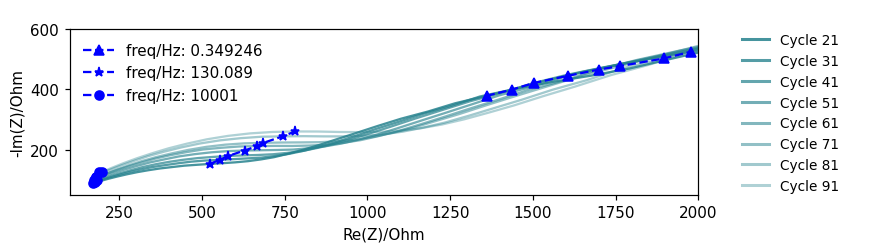

<IPython.core.display.Javascript object>


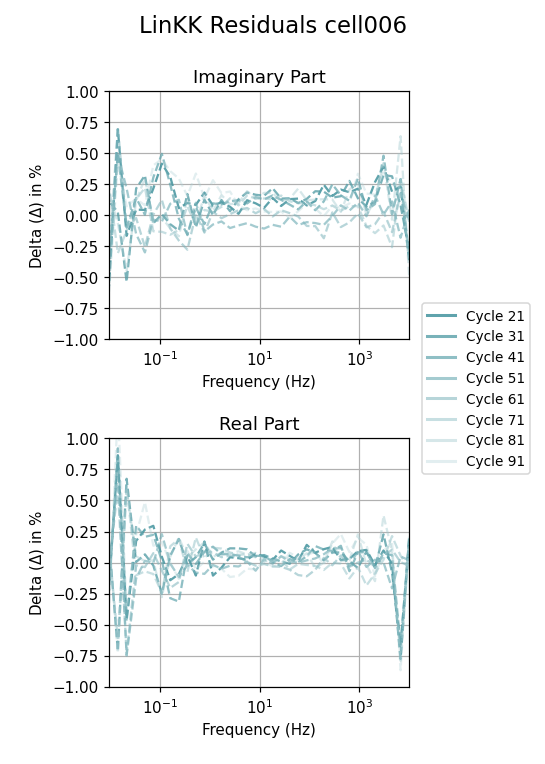

10 1.0 6.999369523492075
20 0.9411784036183082 6.114489489190874
10 1.0 5.693359341887374
20 1.0 5.398130779372121
10 1.0 7.298215432490998
20 0.9931813993687564 6.579545391870994
10 1.0 6.591700669178636
20 0.9714884877858847 6.044219329814244
10 1.0 7.283635125070752
20 0.9951892636282285 6.476272037624166
10 1.0 6.5883503347260195
20 0.960685255325902 5.696542947263961
10 1.0 7.21293353557346
20 0.9861259234070652 6.619371009808421
10 1.0 11.495625170105859
20 0.9168357771325111 10.378584543827598


<IPython.core.display.Javascript object>


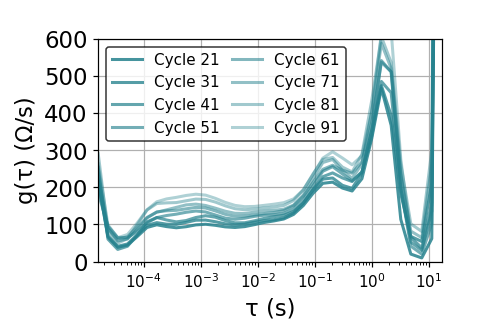

<IPython.core.display.Javascript object>


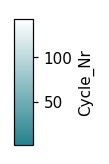

In [142]:
%matplotlib notebook

color_norm = {}
for cell in ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']:
    cell_data = Q_all[Q_all['cell_ID'] == cell]
    color_cell = cell_data['I(uA)_rgl'][5]
    color_norm[cell]= color_cell

color = (plt.cm.viridis(color_norm['cell006'])) # define the color based on the I(uA)

dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
cell = 'cell006' # define the cell

Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis WHERE `cycle_Nr`>20 '
cellx_df = pd.read_sql(sql, Connection)

# plot EIS
fig = plt.figure(figsize=(8,2.3))
ax = plt.axes()
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
    Z_log = np.log10(Z)
    ax.plot(Z[:, 0], Z[:, 1],'-',alpha= 1-0.007*i,c=color,lw=1.5)
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
Cycle_legend = ax.legend(handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.05, 1.05), #upper right outside the plot
    frameon=False,
    fontsize=9,
    ncol=1)
ax.add_artist(Cycle_legend)       


[low,medium,high]=[0.349246,130.089,10001]
for freq in [low,medium,high]:
    if freq<1.2:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='^', label='freq/Hz: '+str(freq),c='b')
    elif 100<freq<8000:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='*', label='freq/Hz: '+str(freq),c='b')
    else:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='o', label='freq/Hz: '+str(freq),c='b')

ax.set_xlabel("Re(Z)/Ohm",{'size':10})
ax.set_ylabel("-Im(Z)/Ohm",{'size':10})

plt.subplots_adjust(right=0.8)
plt.xlim((100,2000))
plt.ylim((50,600))
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(prop={'size':10}, loc='upper left',frameon=False) #bbox_to_anchor=(0, 1)
plt.gcf().subplots_adjust(left=0.08,bottom=0.22)

colors = [color[:3],(1,1,1)]
cmap_name = 'cell_color'
cml = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
norm = matplotlib.colors.Normalize(vmin=1, vmax=143)



# plot LinKK test error
fig = plt.figure(figsize=(5,7))
legend_elements = []

for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j * Z[:, 1]
    M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=0.8, max_M=100, fit_type='complex', add_cap=True)
    alpha = 1 - 0.007 * i
    color_i = cml(norm(i))  # define colormap and norm

    # subplot1 error of imaginary part
    ax1 = plt.subplot(211)
    ax1.plot(f, res_imag * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax1.set_title('Imaginary Part')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(f[-1], f[0])
    ax1.set_xlabel('Frequency (Hz)', {'size': 10})
    ax1.set_ylabel('Delta ($\Delta$) in %', {'size': 10})
    
    # subplot2 error of real part
    plt.subplots_adjust(right=0.75)
    ax2 = plt.subplot(212)
    ax2.plot(f, res_real * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax2.set_title('Real Part')
    ax2.set_xscale('log')
    ax2.grid(True)
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(f[-1], f[0])
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Delta ($\Delta$) in %')    

    # legend handle
    legend_elements.append(Line2D([0], [0], color=color_i, alpha=alpha, lw=2, label=f'Cycle {i}'))

plt.suptitle('LinKK Residuals ' + str(cell), fontsize=15, y=0.98)
plt.subplots_adjust(left=0.2, bottom=0.1, hspace=0.4)  # leave place for achse and legend

# add legend next to subplot2 in right upper
ax2.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 1.2),
    ncol=1,
    fontsize=9,
    frameon=True,
    facecolor='white'
)



# plot DRT 
plt.figure(figsize=(4.5,3))
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j*Z[:, 1]
    iter = 1000  # Example number of iterations
    drt = calc_drt.calc_drt(Z.real, Z.imag, f, iter)
    tau = 1/(f*2*np.pi)
    plt.plot(tau, drt, '-', c=color, alpha= 1-0.007*i, lw=2, label=f'Cycle {i}')
    drt = drt.flatten()
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
    plt.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    ncol=2,
    columnspacing=0.8,
    frameon=True,
   facecolor='white',
   edgecolor='black',
    handlelength=2)

    plt.xscale("log")
    plt.xlim(tau[0], tau[-1])
    plt.ylim(0, 600)
    plt.xlabel('τ (s)', fontdict={'size':15})
    plt.ylabel('g(τ) (Ω/s)', fontdict={'size':15})
    plt.xticks(size=10)
    plt.yticks(size=15)
    plt.grid(True)
    plt.gcf().subplots_adjust(left=0.2,bottom=0.2)

    
# plot colorbar
fig, ax = plt.subplots(figsize=(1, 1.5))
fig.subplots_adjust(right=0.3)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cml,norm=norm), cax=ax, orientation='vertical',label='Cycle_Nr')

plt.show()

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\661346115.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cellx_df = pd.read_sql(sql, Connection)


<IPython.core.display.Javascript object>


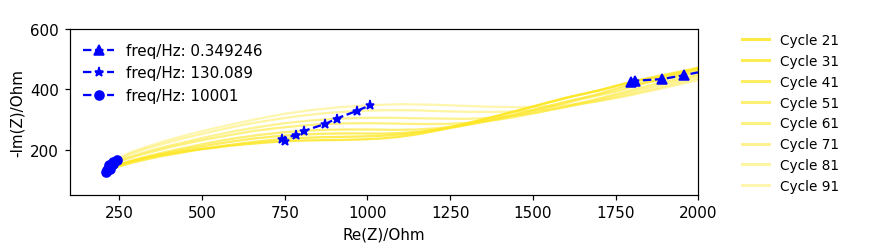

<IPython.core.display.Javascript object>


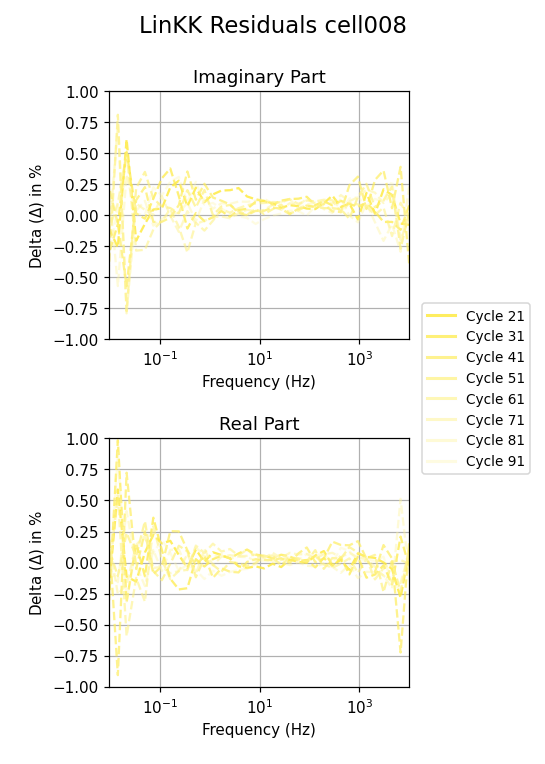

10 1.0 5.742825910529067
20 0.9588385851424199 5.160762442737326
10 1.0 7.496158252380724
20 1.0 6.807747464644501
10 1.0 7.712592951019002
20 0.9941049990719973 7.470928959883502
10 1.0 8.772105399481879
20 0.9062379448535108 7.464934273840036
10 1.0 7.342252753309148
20 0.9981634363113596 6.403556880425179
10 1.0 7.655010510357612
20 1.0 7.199618480387777
10 1.0 6.292672096991114
20 0.9865076210724805 5.623456975231842
10 1.0 8.503921775327864
20 0.9465347165906446 7.880263900467405


<IPython.core.display.Javascript object>


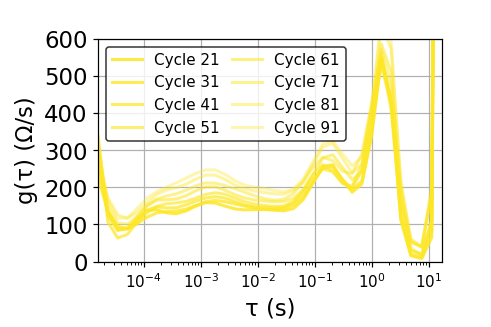

<IPython.core.display.Javascript object>


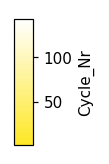

In [144]:
%matplotlib notebook

color_norm = {}
for cell in ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']:
    cell_data = Q_all[Q_all['cell_ID'] == cell]
    color_cell = cell_data['I(uA)_rgl'][5]
    color_norm[cell]= color_cell

color = (plt.cm.viridis(color_norm['cell008'])) # define the color based on the I(uA)

dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
cell = 'cell008' # define the cell

Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis WHERE `cycle_Nr`>20 '
cellx_df = pd.read_sql(sql, Connection)

# plot EIS
fig = plt.figure(figsize=(8,2.3))
ax = plt.axes()
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
    Z_log = np.log10(Z)
    ax.plot(Z[:, 0], Z[:, 1],'-',alpha= 1-0.007*i,c=color,lw=1.5)
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
Cycle_legend = ax.legend(handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.05, 1.05), #upper right outside the plot
    frameon=False,
    fontsize=9,
    ncol=1)
ax.add_artist(Cycle_legend)       


[low,medium,high]=[0.349246,130.089,10001]
for freq in [low,medium,high]:
    if freq<1.2:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='^', label='freq/Hz: '+str(freq),c='b')
    elif 100<freq<8000:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='*', label='freq/Hz: '+str(freq),c='b')
    else:
        ax.plot(cellx_df[cellx_df['freq/Hz']==freq]['Re(Z)/Ohm'],
              cellx_df[cellx_df['freq/Hz']==freq]['-Im(Z)/Ohm'],
              '--', marker='o', label='freq/Hz: '+str(freq),c='b')

ax.set_xlabel("Re(Z)/Ohm",{'size':10})
ax.set_ylabel("-Im(Z)/Ohm",{'size':10})

plt.subplots_adjust(right=0.8)
plt.xlim((100,2000))
plt.ylim((50,600))
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(prop={'size':10}, loc='upper left',frameon=False) #bbox_to_anchor=(0, 1)
plt.gcf().subplots_adjust(left=0.08,bottom=0.22)

colors = [color[:3],(1,1,1)]
cmap_name = 'cell_color'
cml = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
norm = matplotlib.colors.Normalize(vmin=1, vmax=143)



# plot LinKK test error
fig = plt.figure(figsize=(5,7))
legend_elements = []

for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j * Z[:, 1]
    M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=0.8, max_M=100, fit_type='complex', add_cap=True)
    alpha = 1 - 0.007 * i
    color_i = cml(norm(i))  # define colormap and norm

    # subplot1 error of imaginary part
    ax1 = plt.subplot(211)
    ax1.plot(f, res_imag * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax1.set_title('Imaginary Part')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(f[-1], f[0])
    ax1.set_xlabel('Frequency (Hz)', {'size': 10})
    ax1.set_ylabel('Delta ($\Delta$) in %', {'size': 10})
    
    # subplot2 error of real part
    plt.subplots_adjust(right=0.75)
    ax2 = plt.subplot(212)
    ax2.plot(f, res_real * 100, '--', alpha=alpha, c=color_i, lw=1.5)
    ax2.set_title('Real Part')
    ax2.set_xscale('log')
    ax2.grid(True)
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(f[-1], f[0])
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Delta ($\Delta$) in %')    

    # legend handle
    legend_elements.append(Line2D([0], [0], color=color_i, alpha=alpha, lw=2, label=f'Cycle {i}'))

plt.suptitle('LinKK Residuals ' + str(cell), fontsize=15, y=0.98)
plt.subplots_adjust(left=0.2, bottom=0.1, hspace=0.4)  # leave place for achse and legend

# add legend next to subplot2 in right upper
ax2.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 1.2),
    ncol=1,
    fontsize=9,
    frameon=True,
    facecolor='white'
)



# plot DRT 
plt.figure(figsize=(4.5,3))
legend_elements = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr'] == i)][['Re(Z)/Ohm', '-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j*Z[:, 1]
    iter = 1000  # Example number of iterations
    drt = calc_drt.calc_drt(Z.real, Z.imag, f, iter)
    tau = 1/(f*2*np.pi)
    plt.plot(tau, drt, '-', c=color, alpha= 1-0.007*i, lw=2, label=f'Cycle {i}')
    drt = drt.flatten()
    # the cycle number legend
    legend_elements.append(Line2D(
        [0], [0], color=color, alpha=1-0.007*i, lw=2, label=f'Cycle {i}'
    ))
    
    plt.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    ncol=2,
    columnspacing=0.8,
    frameon=True,
   facecolor='white',
   edgecolor='black',
    handlelength=2)

    plt.xscale("log")
    plt.xlim(tau[0], tau[-1])
    plt.ylim(0, 600)
    plt.xlabel('τ (s)', fontdict={'size':15})
    plt.ylabel('g(τ) (Ω/s)', fontdict={'size':15})
    plt.xticks(size=10)
    plt.yticks(size=15)
    plt.grid(True)
    plt.gcf().subplots_adjust(left=0.2,bottom=0.2)

    
# plot colorbar
fig, ax = plt.subplots(figsize=(1, 1.5))
fig.subplots_adjust(right=0.3)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cml,norm=norm), cax=ax, orientation='vertical',label='Cycle_Nr')

plt.show()

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3398381805.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7.5, 1))


<IPython.core.display.Javascript object>


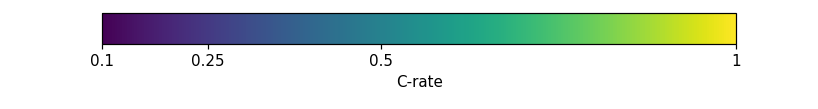

In [12]:
fig, ax = plt.subplots(figsize=(7.5, 1))
fig.subplots_adjust(bottom=0.6)

# plot the Viridis colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), cax=ax, orientation='horizontal')

# define the scale of the colorbar
cbar.set_ticks([0, 0.167, 0.44, 1])
cbar.set_ticklabels(['0.1', '0.25', '0.5', '1'])

# define the title
cbar.set_label('C-rate')

plt.show()

### Impedance data distribution

In [13]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='InES_Test_1234'
connection_name='SSB_Modeling'
db = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008'] 

EIS_all = Series()

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)
     ##formation phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.form_gcpl'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.form_geis WHERE `state of charge`=0 and `cycle_Nr`>4'
    EIS_form = pd.read_sql(sql, Connection)
    EIS_form.insert(EIS_form.shape[1],'I(uA)',i)
    EIS_form.insert(EIS_form.shape[1],'cell_ID',cell)
        
    ##cycling phase
    sql = 'SELECT `control/V/mA` FROM ' +cell+ '.cyc_gcpl WHERE `cycle_Nr`>4'
    control_i = pd.read_sql(sql, Connection)
    i = control_i.at[5,'control/V/mA']*1000 # mA to uA
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis' 
    EIS_cyc = pd.read_sql(sql, Connection)
    EIS_cyc.insert(EIS_cyc.shape[1],'I(uA)',i)
    EIS_cyc.insert(EIS_cyc.shape[1],'cell_ID',cell)
            
    EIS_all = pd.concat([EIS_all, EIS_form, EIS_cyc])
    

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  EIS_all = Series()
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  control_i = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  EIS_form = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:28: UserWarning: pandas only supports SQLAlchemy connectable (en

C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  EIS_cyc = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  control_i = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  EIS_form = pd.read_sql(sql, Connection)
C:\Users\b.zhu\AppData\Local\Temp\ipykernel_10356\3271777624.py:28:

<IPython.core.display.Javascript object>


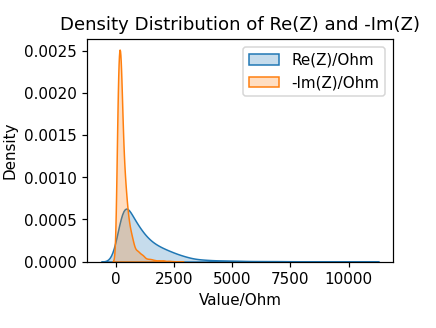

In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(4,3))

sns.kdeplot(EIS_all['Re(Z)/Ohm'], fill=True, label='Re(Z)/Ohm')
sns.kdeplot(EIS_all['-Im(Z)/Ohm'], fill=True, label='-Im(Z)/Ohm')

plt.xlabel('Value/Ohm')
plt.ylabel('Density')
plt.title('Density Distribution of Re(Z) and -Im(Z)')
plt.legend()
plt.subplots_adjust(bottom=0.2, left=0.2) 

plt.show()



<IPython.core.display.Javascript object>


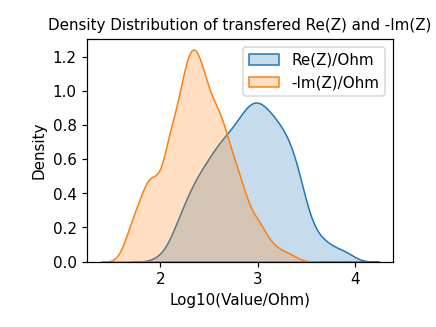

In [15]:
fig = plt.figure(figsize=(4,3))

sns.kdeplot(np.log10(EIS_all['Re(Z)/Ohm']), fill=True, label='Re(Z)/Ohm')
sns.kdeplot(np.log10(EIS_all['-Im(Z)/Ohm']), fill=True, label='-Im(Z)/Ohm')

plt.xlabel('Log10(Value/Ohm)')
plt.ylabel('Density')
plt.title('Density Distribution of transfered Re(Z) and -Im(Z)',fontsize=10)
plt.legend()
plt.subplots_adjust(bottom=0.2, left=0.2) 

plt.show()



### EIS plots of multi cell, at different cycle

<IPython.core.display.Javascript object>


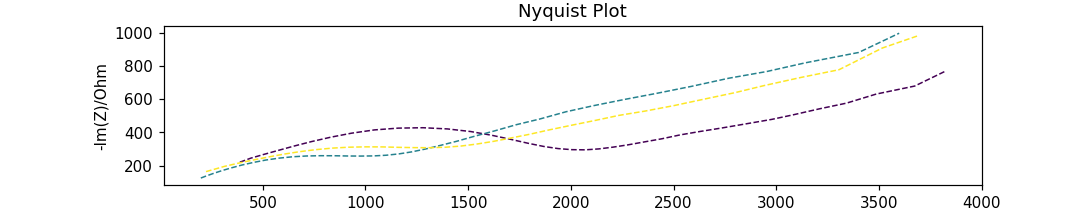

In [16]:
cmap = viridis

cells = ['cell002','cell004','cell006','cell007']
# cells = EIS_all['cell_ID'].unique()

cell_mean_colors = {}

for cell in cells:
    cell_data = Q_all[Q_all['cell_ID'] == cell]
    mean_color = cell_data['I(uA)_rgl'].mean()
    cell_mean_colors[cell]= mean_color

    
plt.figure(figsize=(10,2))
ax = plt.axes()
plt.subplots_adjust(bottom=0.15, left=0.15)
plt.xlabel('Re(Z)/Ohm')
plt.ylabel('-Im(Z)/Ohm')
plt.title('Nyquist Plot')

for cell in cells:
    cell_color = cell_mean_colors[cell]
    cell_data = EIS_all[(EIS_all['cell_ID']==cell) & (EIS_all['cycle_Nr']==91)]
    
    color = plt.cm.viridis(cell_mean_colors[cell])
    
    for cyc in np.unique(cell_data['cycle_Nr']):
        
#         ax.scatter(cell_data['Re(Z)/Ohm'], cell_data['-Im(Z)/Ohm'], s=3, 
#                     alpha=(1-0.01*cyc), c = color)
                    #c= [cell_mean_colors[cell]]*len(cell_data['Re(Z)/Ohm']), cmap=cmap)
            
        ax.plot(cell_data['Re(Z)/Ohm'], cell_data['-Im(Z)/Ohm'],'--', 
                c=plt.cm.viridis(cell_mean_colors[cell]), lw=1)  

plt.show()
